In [109]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torchvision import models


In [110]:
composed = transform.Compose([transform.Resize((224, 224)), transform.ToTensor()])

In [111]:
#get data 
train_data = ImageFolder('skin_dataset_resized/train_set', transform=composed)
val_data = ImageFolder('skin_dataset_resized/val_set', transform=composed)
test_data = ImageFolder('skin_dataset_resized/test_set', transform=composed)

In [112]:
train_data.classes

['benign', 'malignant']

In [113]:
train_data

Dataset ImageFolder
    Number of datapoints: 9200
    Root location: skin_dataset_resized/train_set
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

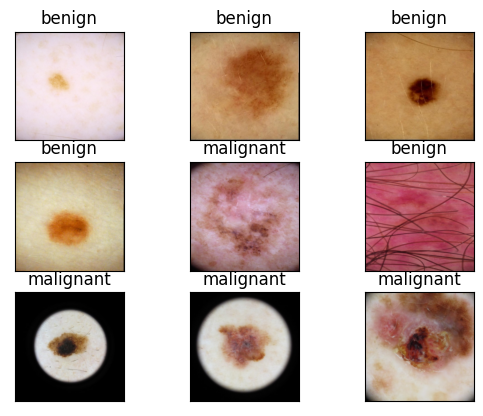

In [114]:
#plot random images in test set
for i in range(0, 9):
  j = np.random.randint(0, 9200)
  plt.subplot(3,3,1+i)
  plt.imshow(train_data[j][0].permute(2,1,0))
  plt.title("benign" if train_data[j][1] == 0 else 'malignant')
  plt.xticks(())
  plt.yticks(())

In [115]:
#use dataloader 
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [116]:
#set device to use gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [117]:
#use transferlearning for model
transfer_model = models.efficientnet_b0(models.EfficientNet_B0_Weights)

In [118]:
torch.cuda.is_available()

True

In [119]:
transfer_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [120]:
transfer_model.fc1 = nn.Dropout(p=0.5)
transfer_model.fc2 = nn.Dropout(p=0.5)
transfer_model.fc3 = nn.Linear(1536, 2)


In [121]:
transfer_model = transfer_model.to(device)

In [122]:
lossfn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(transfer_model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optim, 3, gamma=0.1)

In [123]:
len(train_loader)

575

In [124]:
epochs = 10
train_l = []
val_l = []

train_size = len(train_loader.dataset)
train_batches = len(train_loader)

val_size = len(val_loader.dataset)
val_batches = len(val_loader)


for epoch in range(epochs):
  print(f'Epoch: {epoch+1}')
  
  train_loss = 0
  train_correct = 0
  train_samples = 0
  
  val_loss = 0
  val_correct = 0
  val_samples = 0
  
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device) 
    transfer_model.train()

    pred = transfer_model(X)
    loss = lossfn(pred, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss += loss.item()
    train_correct += (pred.argmax(1) == y).sum().item()
    train_samples = pred.shape[0]

    if batch % 36 == 0:
      loss, current = loss.item(), len(X) * batch
      print(f'loss: {loss:.8f} | [{current:05d}/{train_size}]')

  train_loss /= train_batches
  train_correct /= train_size
  
  print(f'avgloss: {train_loss:.8f} | acc: {train_correct*100:.2f}%')

  train_l.append(train_loss)
  
  #scheduler.step()
  
  transfer_model.eval()
  with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      pred = transfer_model(X)
      loss = lossfn(pred, y)
      
      val_loss += loss
      val_correct += (pred.argmax(1) == y).sum().item()
      val_samples += pred.shape[0]
    
    val_loss /= val_batches
    val_correct /= val_size

    val_l.append(val_loss)
    print(f'Validation | avgloss: {val_loss:.8f} | acc: {val_correct*100:.2f}%')




Epoch: 1
loss: 7.92018890 | [00000/9200]
loss: 1.25748694 | [00576/9200]
loss: 0.86799383 | [01152/9200]
loss: 0.42612538 | [01728/9200]
loss: 0.07775839 | [02304/9200]
loss: 0.49467066 | [02880/9200]
loss: 0.57960856 | [03456/9200]
loss: 0.11090727 | [04032/9200]
loss: 0.05890903 | [04608/9200]
loss: 0.19636670 | [05184/9200]
loss: 0.47806734 | [05760/9200]
loss: 0.05862086 | [06336/9200]
loss: 0.24935420 | [06912/9200]
loss: 0.96341056 | [07488/9200]
loss: 0.17302006 | [08064/9200]
loss: 0.21736439 | [08640/9200]
avgloss: 0.59852251 | acc: 85.71%
Validation | avgloss: 0.20931920 | acc: 92.64%
Epoch: 2
loss: 0.12867045 | [00000/9200]
loss: 0.14131379 | [00576/9200]
loss: 0.21710922 | [01152/9200]
loss: 0.19015466 | [01728/9200]
loss: 0.06346941 | [02304/9200]
loss: 0.17883033 | [02880/9200]
loss: 0.18598098 | [03456/9200]
loss: 0.41318950 | [04032/9200]
loss: 0.08595733 | [04608/9200]
loss: 0.22802140 | [05184/9200]
loss: 0.20089671 | [05760/9200]
loss: 0.08407117 | [06336/9200]
loss:

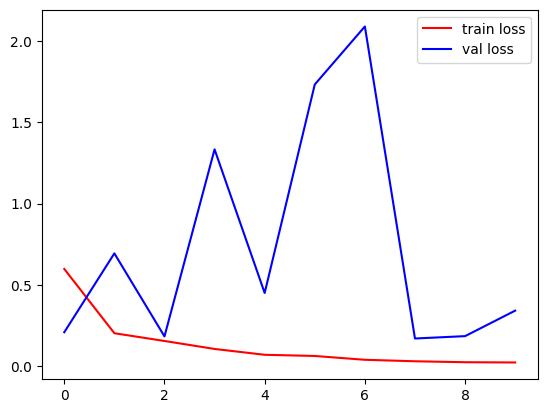

In [149]:
plt.plot(train_l, c='r')
plt.plot(list(map(lambda x: x.detach().cpu().numpy(), val_l)), c='b')
plt.legend(['train loss', 'val loss'])

In [125]:
torch.save(transfer_model.state_dict(), 'effnetb3_cancer_skin.pt')

In [151]:
load_model = models.efficientnet_b0()
#load_model.fc1 = nn.Dropout(p=.2)
#load_model.fc2 = nn.Dropout(p=.2)
load_model.fc3 = nn.Linear(1280, 2)
load_model.load_state_dict(torch.load('effnetb0_cancer_skin.pt'))
load_model = load_model.to(device)

In [152]:
predd = []
targets = []
load_model.eval
with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    pred = load_model(X)
    predd.append(pred)
    targets.append(y)

In [153]:
predd = torch.cat(predd)
targets = torch.cat(targets)
torch.mean(predd.argmax(1).eq(targets).float())

tensor(0.8318, device='cuda:0')